In [1]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from collections import OrderedDict
%matplotlib inline

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits

%matplotlib inline

# 2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値

$i$ : 配列の行方向のインデックス

$j$ : 配列の列方向のインデックス

$m$ : 出力チャンネルのインデックス

$K$ : 入力チャンネル数

$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

$x_{(i+s),(j+t),k}$: 入力の配列の(i+s)行(j+t)列、kチャンネルの値

$w_{s,t,k,m}$: 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\ b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配  $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\ \frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。


MNISTはデータサイズが大きいので、いったん[Optical Recognition of Handwritten Digits Data Set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)のコピーである、[sklearn.datasets.load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)を使って、正しく動いているか検証してみましょう。

### 【テストデータ作成】

(1797, 8, 8)
0


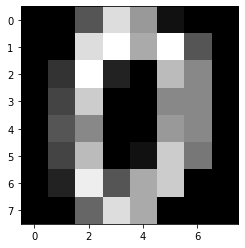

1


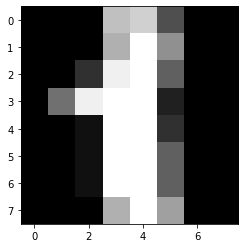

(1797, 1, 8, 8)


In [2]:
X,y = load_digits(n_class = 10, return_X_y = True, as_frame = False)
X = X.reshape((-1,8,8))
print(X.shape)
for i in range(2):
    print(y[i])
    plt.imshow(X[i],"gray")
    plt.show()

X = X[:, np.newaxis, :, :]
print(X.shape)

標準化/正規化ももちろん必須なので、してあげましょう。

モノクロ画像なので、チャンネル側がありませんが、reshapeして、チャンネル方向に拡張してください。

In [3]:
# 正規化
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(np.max(X)) # 1.0
print(np.min(X)) # 0.0

1.0
0.0


In [4]:
# one-hot-encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64

(1797,)
(1797, 10)
float64


In [5]:
#split
X_train,X_test,y_train,y_test = train_test_split(X,y_one_hot)

In [6]:
X_train.shape

(1347, 1, 8, 8)

In [7]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 【解答】conv関数

In [19]:
class Conv2d:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def _calc_out_shape(self, Nin, fh, fw):
        #NCHWの場合
        h, w = Nin.shape[2],Nin.shape[3]

        out_h = int((h + 2*self.pad - fh) / self.stride +1)
        out_w = int((w + 2*self.pad - fw) / self.stride + 1)

        return out_h, out_w

    def forward(self, X):
        FN, C, FH, FW = self.W.shape
        N, C, H, W =X.shape
        out_h, out_w = self._calc_out_shape(X, FH, FW)
        
        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        
        print("after np.dot shape : {}".format(out.shape))
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        print("out shape : {}".format(out.shape))
        
        self.X = X
        self.col = col
        self.col_W = col_W

        return out    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        
        self.dW = self.dW.transpose(1,0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        
        dX = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        return dX
        
        

In [20]:
W = np.random.randn(32,1,3,3)
#print(W.shape)
#col_W = W.reshape(32, -1).T # フィルターの展開
#col_W.shape
b = np.zeros(32,)

In [21]:
test = Conv2d(W,b)
out = test.forward(X_train)
out.shape

after np.dot shape : (48492, 32)
out shape : (1347, 32, 6, 6)


(1347, 32, 6, 6)

In [22]:
back = test.backward(out)
back.shape

(1347, 1, 8, 8)

shapeの遷移は、

* 入力時 : (1347,1,8,8)
* forward propagation出力時 : (1347,32,6,6)
* back propagation出力時 : (1347,1,8,8)

となったので、数値は見ていないがshapeの動きは正しいと思われる。


# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} = \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\ N_{w,out} = \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

$h$ が高さ方向、 $w$ が幅方向である

### 【解答】

In [23]:
def calc_out_shape(Nin, F=(3,3), P=(0, 0), S=(1,1)):
    #NCHWの場合
    h, w = Nin.shape[2],Nin.shape[3]
    #print(h,w)
    fh, fw = F[0], F[1]
    ph, pw = P[0], P[1]
    sh, sw = S[0], S[1]
    
    h_out = int((h + 2*ph - fh) / sh +1)
    w_out = int((w + 2*pw - fw) / sw + 1)
    
    return h_out, w_out

In [24]:
calc_out_shape(X)

(142, 142)

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）

$S_{h}, S_{w}$  : 高さ方向（h）と幅方向（w）のストライドのサイズ

$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス

$a_{i,j,m}$: 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス 
$(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

### 【解答】

In [25]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.X = None
        self.arg_max = None
        
    def forward(self, X):
        N,C,H,W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        #print("col:{}".format(col.shape))
        col = col.reshape(-1, self.pool_h*self.pool_w)
        #print("im2col out & reshape:{}\n".format(col))
        
        arg_max = np.argmax(col, axis=1) # colの各配列のなかで一番大きい値のインデックスを持っている配列
        #print(arg_max[0])
        #最大値(2)
        out = np.max(col, axis=1)
        
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        #print("out:\n{}\n".format(out))

        self.X = X
        self.arg_max = arg_max

        return out

    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1) # doutを順番入れ替え　(0,1,2,3) (0,3,1,2) (0,2,3,1) 元に戻ってる 
        print("transpose:{}".format(dout.shape))
        #print("dout transpose:{}".format(dout))
        
        pool_size = self.pool_h * self.pool_w # pool_sizeを計算
        print("pool_size:{}".format(pool_size))
    
        dmax = np.zeros((dout.size, pool_size)) # dmax = (doutのサイズ,プールサイズ)
        #print("dmax_size:{}".format(dmax.shape))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # dmaxの0~arg_max.size行の最大値インデックス列に、doutをflattenしたものを追加していく
        print("dmax_size(flatten):{}".format(dmax.shape))
        dmax = dmax.reshape(dout.shape + (pool_size,)) # 
        print("dmax_size(reshape):{}".format(dmax.shape))
        #print("dmax:{}".format(dmax))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) # dcolはdmaxをreshapeして作る
        print("dcol_size:{}".format(dcol.shape))
        #print("dcol:{}".format(dcol))
        dX = col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad) # dcolをcol2imに通して出力
        print("dX_size:{}".format(dX.shape))
        print(dX)
        
        return dX

In [26]:
test3 = np.random.randint(0,9,(1,1,4,4))
test3

array([[[[1, 5, 0, 0],
         [7, 4, 7, 4],
         [4, 2, 2, 7],
         [3, 8, 0, 5]]]])

In [27]:
tmp = Pooling(2,2,stride=2, pad=0)

In [28]:
pool_test = tmp.forward(test3)
pool_test.shape

(1, 1, 2, 2)

In [29]:
pooling_back = tmp.backward(pool_test)
pooling_back.shape

transpose:(1, 2, 2, 1)
pool_size:4
dmax_size(flatten):(4, 4)
dmax_size(reshape):(1, 2, 2, 1, 4)
dcol_size:(4, 4)
dX_size:(1, 1, 4, 4)
[[[[0. 0. 0. 0.]
   [7. 0. 7. 0.]
   [0. 0. 0. 7.]
   [0. 8. 0. 0.]]]]


(1, 1, 4, 4)

# 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。



### 【解答】

In [30]:
class Average_Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, X):
        N,C,H,W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        #print(col.shape)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        print(col[0])
        #最大値(2)
        out = np.mean(col, axis=1)
        print(out[0])
        
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
        

In [31]:
temp = Average_Pooling(3,3)
mean_pool = temp.forward(out)
mean_pool[0][0]

[-1.34046124 -1.38997485 -0.17909312 -1.96367119 -1.27748191 -0.9546097
 -2.45600279 -0.36730588 -0.12372623]
-1.1169252115008323


array([[-1.11692521, -1.11012938, -1.0477864 , -0.97479992],
       [-1.17657284, -1.01588245, -1.13753636, -1.09074083],
       [-1.21395513, -0.81325865, -0.85811374, -0.6837504 ],
       [-1.34906655, -0.84029381, -0.64171833, -0.25780742]])

# 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。



### 【解答】平滑化関数

In [32]:
class Flatten:
    def __init__(self):
        self.shape = None
    
    def forward(self, Z):
        self.shape = Z.shape
        return Z.reshape(self.shape[0], np.prod(self.shape[1:]))
    
    def backward(self, dX):
        return dX.reshape(self.shape)

In [33]:
print("平滑化前:{}".format(out.shape))
flat = Flatten()
dx = flat.forward(out)
print("平滑化関数出力:{}".format(dx.shape))
z = flat.backward(dx)
print("元に戻す:{}".format(z.shape))

平滑化前:(1347, 32, 6, 6)
平滑化関数出力:(1347, 1152)
元に戻す:(1347, 32, 6, 6)


ちゃんとshape変更できている。

### 時間計測

ちょっと気になったので、np.ravelとnp.prodのどっちが早いのか測ってみたところ、prodの方が早かった。

なので平滑化はprodで実装する。

In [34]:
%%timeit -r 1 -n 1
# 簡略化のため1回分しか計測していないが、10000回やって平均とってもprodのが早かった。
np.prod(out.shape)

62.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [35]:
%%timeit  -r 1 -n 1
np.ravel(out)

11.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

### MNISTデータの準備

In [36]:
from keras.datasets import mnist

Using TensorFlow backend.


In [37]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 1, 28, 28)
(10000, 1, 28, 28)
uint8


In [38]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y_train[:, np.newaxis])
print(y_train.shape) # (100000,)
print(y_one_hot.shape) # (100000, 2)
print(y_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [39]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_one_hot)


In [40]:
X_train.shape

(45000, 1, 28, 28)

In [41]:
y_train.shape

(45000, 10)

In [42]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
        
    Returns
    -------
    col : 2次元配列
    """
    #print(input_data)
    #print("im2col input shape :{}".format(input_data.shape))
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
        
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
        
    #print("before transpose shape : {}".format(col.shape))
    #print(col)
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    #print("after im2col shape : {}".format(col.shape))
    return col

In [43]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [44]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [45]:
# ReLU関数クラス

class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dX = dout
        
        return dX            


# シグモイド関数クラス

class Simoid:
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        self.out = 1 / (1+np.exp(-X))
        return self.out
    
    def backward(self, dout):
        dX = doutt * (1.0 - self.out) * self.out
        return dX
    
    
# 全結合層クラス

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.X = None
        self.original_X_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None
        
    def forward(self, X):
        # テンソル対応
        self.original_X_shape = X.shape
        X = X.reshape(X.shape[0], -1)
        self.X = X
        
        out = np.dot(self.X, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.db =np.sum(dout, axis=0)
        
        dX = dX.reshape(*self.original_X_shape) # 入力データの形状に戻す(テンソル対応)
        
        return dX
    
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ
        
    def forward(self, X, t):
        """
        X : 入力データ
        t : 教師データ
        """
        self.t = t
        self.y = softmax(X)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dX = (self.y - self.t) / batch_size
        else:
            dX = self.y.copy()
            dX[np.arrange(batch_size), self.t] -= 1
            dX = dX / batch_size
        
        return dX
    

    
# 畳み込み層クラス

class Conv2d:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def _calc_out_shape(self, Nin, fh, fw):
        #NCHWの場合
        h, w = Nin.shape[2],Nin.shape[3]

        out_h = int((h + 2*self.pad - fh) / self.stride +1)
        out_w = int((w + 2*self.pad - fw) / self.stride + 1)

        return out_h, out_w

    def forward(self, X):
        FN, C, FH, FW = self.W.shape
        N, C, H, W =X.shape
        out_h, out_w = self._calc_out_shape(X, FH, FW)
        
        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        
        #print("after np.dot shape : {}".format(out.shape))
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        #print("out shape : {}".format(out.shape))
        
        self.X = X
        self.col = col
        self.col_W = col_W

        return out    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        
        self.dW = self.dW.transpose(1,0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        
        dX = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        return dX

    
# プーリングクラス

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.X = None
        self.arg_max = None
        
    def forward(self, X):
        N,C,H,W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        #print("col:{}".format(col.shape))
        col = col.reshape(-1, self.pool_h*self.pool_w)
        #print("im2col out & reshape:{}\n".format(col))
        
        arg_max = np.argmax(col, axis=1) # colの各配列のなかで一番大きい値のインデックスを持っている配列
        #print(arg_max[0])
        #最大値(2)
        out = np.max(col, axis=1)
        
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        #print("out:\n{}\n".format(out))

        self.X = X
        self.arg_max = arg_max

        return out

    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1) # doutを順番入れ替え　(0,1,2,3) (0,3,1,2) (0,2,3,1) 元に戻ってる 
        #print("transpose:{}".format(dout.shape))
        #print("dout transpose:{}".format(dout))
        
        pool_size = self.pool_h * self.pool_w # pool_sizeを計算
        #print("pool_size:{}".format(pool_size))
    
        dmax = np.zeros((dout.size, pool_size)) # dmax = (doutのサイズ,プールサイズ)
        #print("dmax_size:{}".format(dmax.shape))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # dmaxの0~arg_max.size行の最大値インデックス列に、doutをflattenしたものを追加していく
        #print("dmax_size(flatten):{}".format(dmax.shape))
        dmax = dmax.reshape(dout.shape + (pool_size,)) # 
        #print("dmax_size(reshape):{}".format(dmax.shape))
        #print("dmax:{}".format(dmax))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) # dcolはdmaxをreshapeして作る
        #print("dcol_size:{}".format(dcol.shape))
        #print("dcol:{}".format(dcol))
        dX = col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad) # dcolをcol2imに通して出力
        #print("dX_size:{}".format(dX.shape))
        #print(dX)
        
        return dX



In [46]:
conv_param={'filter_num':32, 'filter_size':3, 'pad':0, 'stride':1}

class SimpleConvnet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), conv_param=conv_param, hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの作成
        self.layers = OrderedDict()
        self.layers["Conv1"] = Conv2d(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers["ReLU1"] = ReLU()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["ReLU2"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        
        self.last_layer = SoftmaxWithLoss()
        
        print("レイヤの初期化完了")
    
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        
        #print("predict完了")
        
        return X
    
    def loss(self, X, t):
        """
        損失関数を求める
        引数のXは入力データ、tは正解ラベル
        例：loss(X_train, y_train)
        """
        y = self.predict(X)
        #print("loss完了")
        
        return self.last_layer.forward(y, t)
    
    def accuracy(self, X, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
            
        acc = 0.0
        
        for i in range(int(X.shape[0] / batch_size)):
            tX = X[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tX)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == y)
        
        #print("accuracy完了")
        
            
        return acc / X.shape[0]

    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]            
            

In [47]:
# optimizerクラスまとめ

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [48]:
class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=5, mini_batch_size=100,
                 optimizer='AdaGrad', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=False):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [49]:
%%timeit -r 1 -n 1
max_epochs = 5

network = SimpleConvnet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, X_train, y_train, X_val, y_val,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='AdaGrad', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")
"""
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
"""

レイヤの初期化完了
Saved Network Parameters!
8min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [55]:
network = SimpleConvnet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
network.load_params()

レイヤの初期化完了


In [56]:
tmp = network.predict(X_test)
pred = np.argmax(tmp,axis=1)
pred

array([7, 2, 1, ..., 4, 5, 6])

In [57]:
print("Accuracy_score: {}".format(accuracy_score(y_test, pred)))

Accuracy_score: 0.9819


# 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


* 1.畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
* 2.ReLU
* 3.最大プーリング
* 4.畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
* 5.ReLU
* 6.最大プーリング
* 7.平滑化
* 8.全結合層　出力ノード数120
* 9.ReLU
* 10.全結合層　出力ノード数84
* 11.ReLU
* 12.全結合層　出力ノード数10
* 13.ソフトマックス関数

# 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》


[Applications - Keras Documentation](https://keras.io/ja/applications/)



# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.


* 入力サイズ : 144×144, 3チャンネル
* フィルタサイズ : 3×3, 6チャンネル
* ストライド : 1
* パディング : なし

2.


* 入力サイズ : 60×60, 24チャンネル
* フィルタサイズ : 3×3, 48チャンネル
* ストライド　: 1
* パディング : なし

3.


* 入力サイズ : 20×20, 10チャンネル
* フィルタサイズ: 3×3, 20チャンネル
* ストライド : 2
* パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。



In [58]:
def q9_func(X, filter_size, b, S=1, P=0):
    FN, C, FH, FW = filter_size.shape  
    N, C, H, W =X.shape
    out_h = int((H + 2*P - FH) / S +1)
    out_w = int((W + 2*P - FW) / S + 1)  

    col = im2col(X, FH, FW, S, P)
    #print(col.shape)
    col_W = filter_size.reshape(FN, -1).T # フィルターの展開
    #print(col_W.shape)
    weight = col_W.shape[0] * col_W.shape[1]

    out = np.dot(col, col_W) + b
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
    return out, weight

### 問1
入力サイズ : 144×144, 3チャンネル

フィルタサイズ : 3×3, 6チャンネル

ストライド : 1

パディング : なし

In [59]:
b = np.zeros((1,1,6))

X = np.random.randn(1, 3, 144, 144)
filter_size = np.zeros((6, 3, 3, 3))

out, weight = q9_func(X, filter_size, b)

print("解答 : \n出力サイズ：{}\n重み : {}{}".format(out.shape, weight, filter_size.shape))
print("バイアス : {}".format(b.shape))

解答 : 
出力サイズ：(1, 6, 142, 142)
重み : 162(6, 3, 3, 3)
バイアス : (1, 1, 6)


### 問2

入力サイズ : 60×60, 24チャンネル

フィルタサイズ : 3×3, 48チャンネル

ストライド　: 1

パディング : なし

In [60]:
b = np.zeros((1,1,48))

X = np.random.randn(1, 24, 60, 60)
filter_size = np.zeros((48, 24, 3, 3))

out, weight = q9_func(X, filter_size, b)

print("解答 : \n出力サイズ：{}\n重み : {}{}".format(out.shape, weight, filter_size.shape))
print("バイアス : {}".format(b.shape))

解答 : 
出力サイズ：(1, 48, 58, 58)
重み : 10368(48, 24, 3, 3)
バイアス : (1, 1, 48)


### 問3

入力サイズ : 20×20, 10チャンネル

フィルタサイズ: 3×3, 20チャンネル

ストライド : 2

パディング : なし

In [61]:
b = np.zeros((1,1,20))

X = np.random.randn(1, 10, 20, 20)
#print(X[0][0][0])
filter_size = np.ones((20, 10, 3, 3))

out, weight = q9_func(X, filter_size, b, 2)

print("解答 : \n出力サイズ：{}\n重み : {}{}".format(out.shape, weight, filter_size.shape))
print("バイアス : {}".format(b.shape))

解答 : 
出力サイズ：(1, 20, 9, 9)
重み : 1800(20, 10, 3, 3)
バイアス : (1, 1, 20)


strideが2なので、(20,20)の列の内18までしか畳み込めておらず、19,20行列目は無視されている。
strideを1にするか、フィルタをsirideとかけたときに20の公約数になるように調節すればちゃんと全部使われるはず。

# 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


* 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
* 高さや幅方向を持たない1×1のフィルタの効果